In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd
from functools import partial

from prepare_plasticc import config
from tokenizer import LCTokenizer
from viz import plot_lightcurve
from gaussian_process import fit_2d_gp
import time

from models.patchgpt import PatchGPT, PatchGPTConfig
import torch

/opt/anaconda3/envs/gpt-ts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('plasticc/plasticc_train_lightcurves.csv.gz')
#df = pd.read_csv('plasticc/plasticc_test_lightcurves_02.csv.gz')

In [3]:
object_ids = np.unique(df['object_id'].values)

In [4]:
tokenizer = LCTokenizer(-10000, 10000, 500, 1000, 500, bands=config["bands"],
                            transform=np.arcsinh, inverse_transform=np.sinh,
                            min_sn=3, window_size=5)

In [5]:
start_time = time.time()
#tokenizer.encode(df)
print(time.time() - start_time)

2.2172927856445312e-05


0.15525078773498535 True


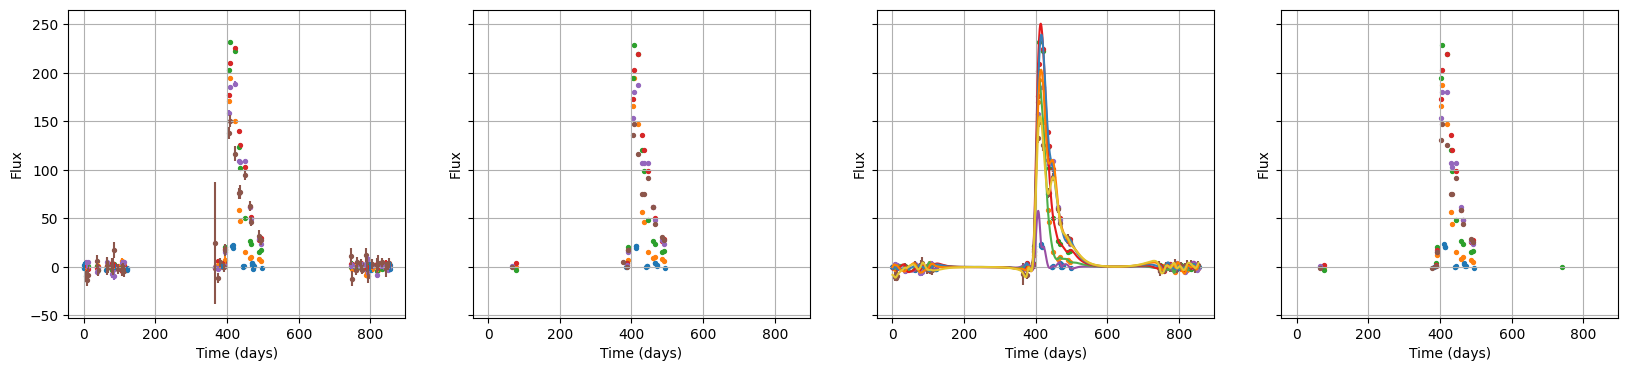

In [59]:
for object_id in object_ids[8:9]:
    df_object = df.loc[df['object_id'] == object_id]
    df_object.loc[:, 'mjd'] = df_object.loc[:, 'mjd'] - min(df_object['mjd']) 
    start_time = time.time()
    resampled_df, (sampled_times, sampled_obs, _, sampled_mask), success = fit_2d_gp(df_object, config['pb_wavelengths'], sample_interval=1)
    print(time.time() - start_time, success)
    axes = plot_lightcurve([df_object, tokenizer.decode(tokenizer.encode(df_object)), resampled_df, tokenizer.decode(tokenizer.encode(resampled_df))])
    axes[2].plot(sampled_times, sampled_obs[0,:], color=config['pb_colors'][0])
    axes[2].plot(sampled_times, sampled_obs[1,:], color=config['pb_colors'][1])
    axes[2].plot(sampled_times, sampled_obs[2,:], color=config['pb_colors'][2])
    axes[2].plot(sampled_times, sampled_obs[3,:], color=config['pb_colors'][3])
    axes[2].plot(sampled_times, sampled_obs[4,:], color=config['pb_colors'][4])
    axes[2].plot(sampled_times, sampled_obs[5,:], color=config['pb_colors'][5])

In [60]:
patch_size = 7

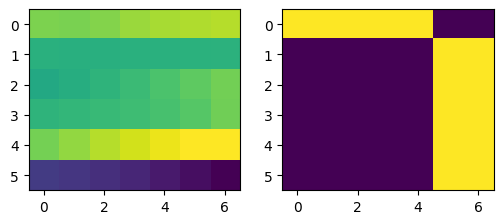

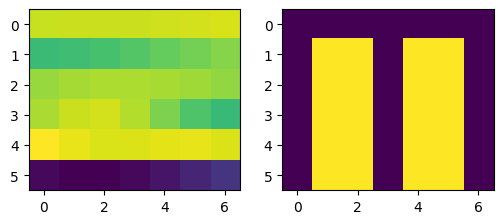

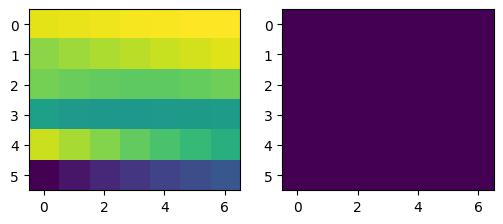

In [61]:
for i in range(3):
    fig, axes = plt.subplots(1,2, figsize=(6,3))
    axes[0].imshow(sampled_obs[:,i*patch_size:(i+1)*patch_size])
    axes[1].imshow(sampled_mask[:,i*patch_size:(i+1)*patch_size])
    plt.show()

In [76]:
patchify = PatchGPT.from_pretrained('adammoss/patch-pretrain-mask-5')

In [84]:
patchify.random_mask_ratio = 0.5

In [85]:
patchify.eval()

PatchGPT(
  (patchify): Patchify(
    (to_patches): Rearrange('b c (n p) -> b n (p c)', p=7)
  )
  (unpatchify): UnPatchify(
    (from_patches): Rearrange('b n (p c) -> b c (n p)', p=7)
  )
  (patch_embedding): Sequential(
    (0): LayerNorm((42,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=42, out_features=384, bias=True)
    (2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (position_embedding_table): Embedding(1024, 384)
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=384, out_features=64, bias=False)
            (query): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
            (distance_embedding): Embedding(2047, 64)
          )
        )
        (proj): Linear(in_features=384, out_features=

In [86]:
x = torch.tensor(np.expand_dims(np.arcsinh(sampled_obs), 0), dtype=torch.float32).transpose(1, 2)
mask = torch.tensor(np.expand_dims(sampled_mask, 0), dtype=torch.int32).transpose(1, 2)

In [87]:
output = patchify(x, attention_mask=mask)

In [88]:
output.loss

tensor(0.1801, grad_fn=<MeanBackward0>)

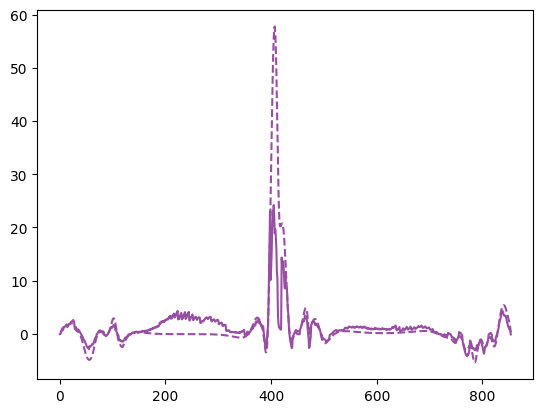

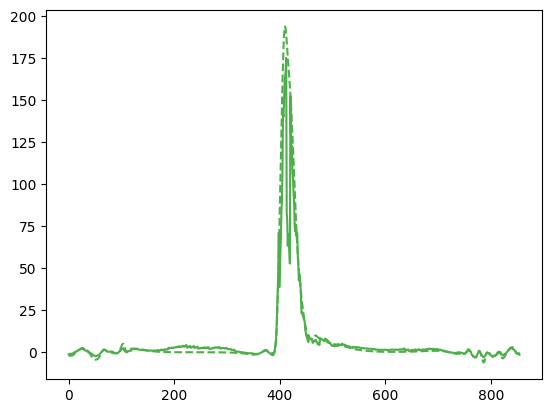

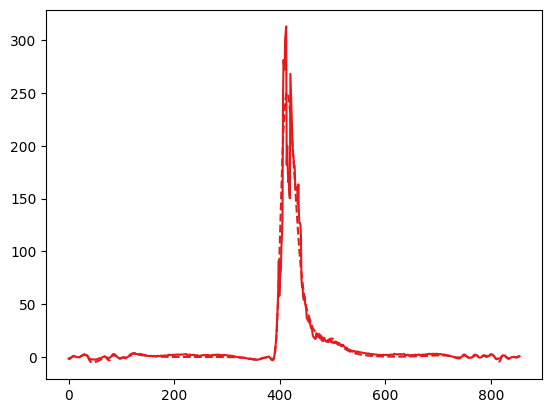

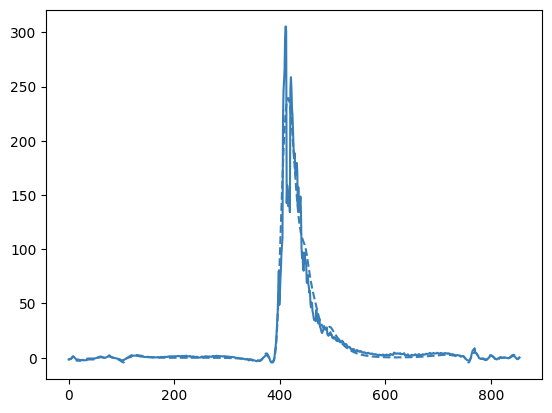

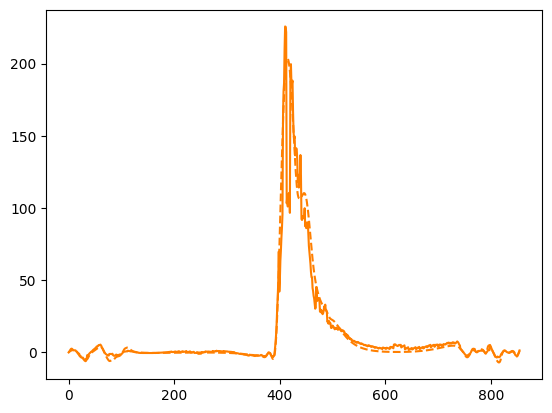

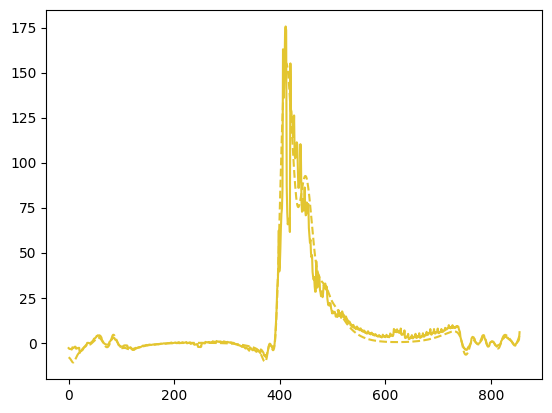

In [91]:
for i in range(6):
    plt.plot(sampled_times, np.sinh(output.x_pred.detach().numpy()[0,0:sampled_times.shape[0],i]), color=config['pb_colors'][i])
    plt.plot(sampled_times, (sampled_obs[i,:]), color=config['pb_colors'][i], linestyle='--')
    plt.show()

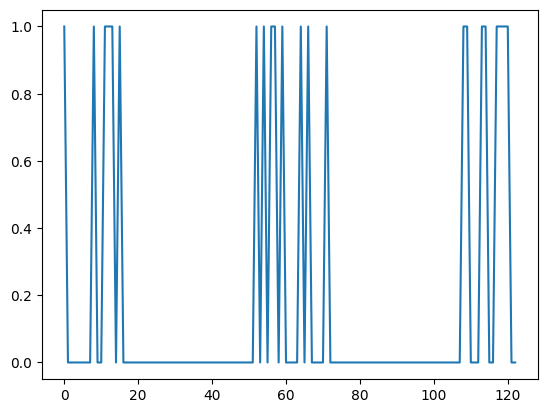

In [90]:
plt.plot(output.mask.cpu().numpy()[0])